In [48]:
!pip install torch_geometric

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

## CORA Dataset Overview

The CORA dataset is a commonly used benchmark dataset in the field of machine learning, especially for graph neural networks and node classification tasks. It consists of a citation network of scientific publications.

**Nodes:** Each node in the graph represents a scientific paper. There are 2,708 nodes in the CORA dataset.

**Edges:** An edge between two nodes indicates that one paper cites the other. There are 5,429 edges in the dataset.

**Features:** Each node has a 1,433-dimensional feature vector. This vector is a sparse representation of the words in the paper's abstract, indicating which words are present in the abstract.

**Labels:** Each node is labeled with one of 7 classes, representing the category of the paper:
*   Case-Based
*   Genetic Algorithms
*   Neural Networks
*   Probabilistic Methods
*   Reinforcement Learning
*   Rule Learning
*   Theory

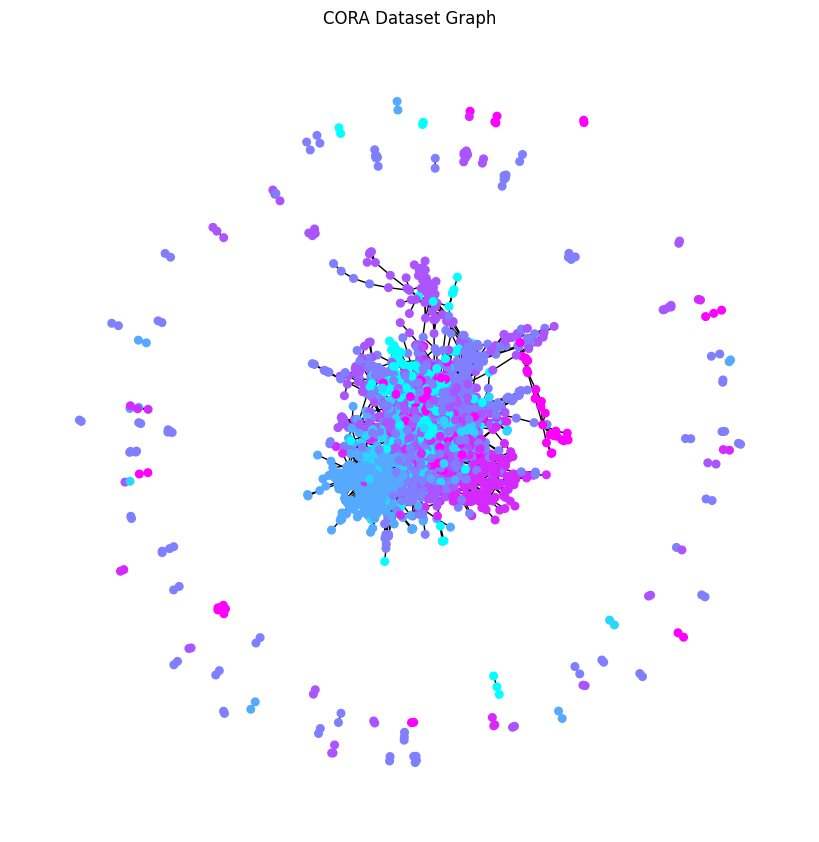

In [49]:
# Load only one graph
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Visualize it via Networkx
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(8, 8))
nx.draw(G, node_size=30, node_color=data.y, cmap='cool')
plt.title('CORA Dataset Graph')
plt.show()

In [50]:
# Extract features, adjacency matrix, and labels
features = data.x.numpy()
labels = data.y.numpy()
edge_index = data.edge_index.numpy()

# Print feature matrix and labels for the first 5 nodes
print("Feature matrix (first 5 nodes):")
print(features[:5])
print("\nLabels (first 5 nodes):")
print(labels[:5])

Feature matrix (first 5 nodes):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Labels (first 5 nodes):
[3 4 4 0 3]


In [51]:
# Create adjacency matrix from edge_index
num_nodes = features.shape[0]

# - A: Adjacency matrix initialized to zeros
A = np.zeros((num_nodes, num_nodes))
# - zip(edge_index[0], edge_index[1]): Pairs of edges
for i, j in zip(edge_index[0], edge_index[1]):
    # - A[i, j] = 1: Setting the adjacency matrix entries to 1 where there is an edge
    A[i, j] = 1

# Add self-loops with I: Identity matrix for adding self-loops
I = np.eye(num_nodes)
A_hat = A + I

print(A_hat)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]


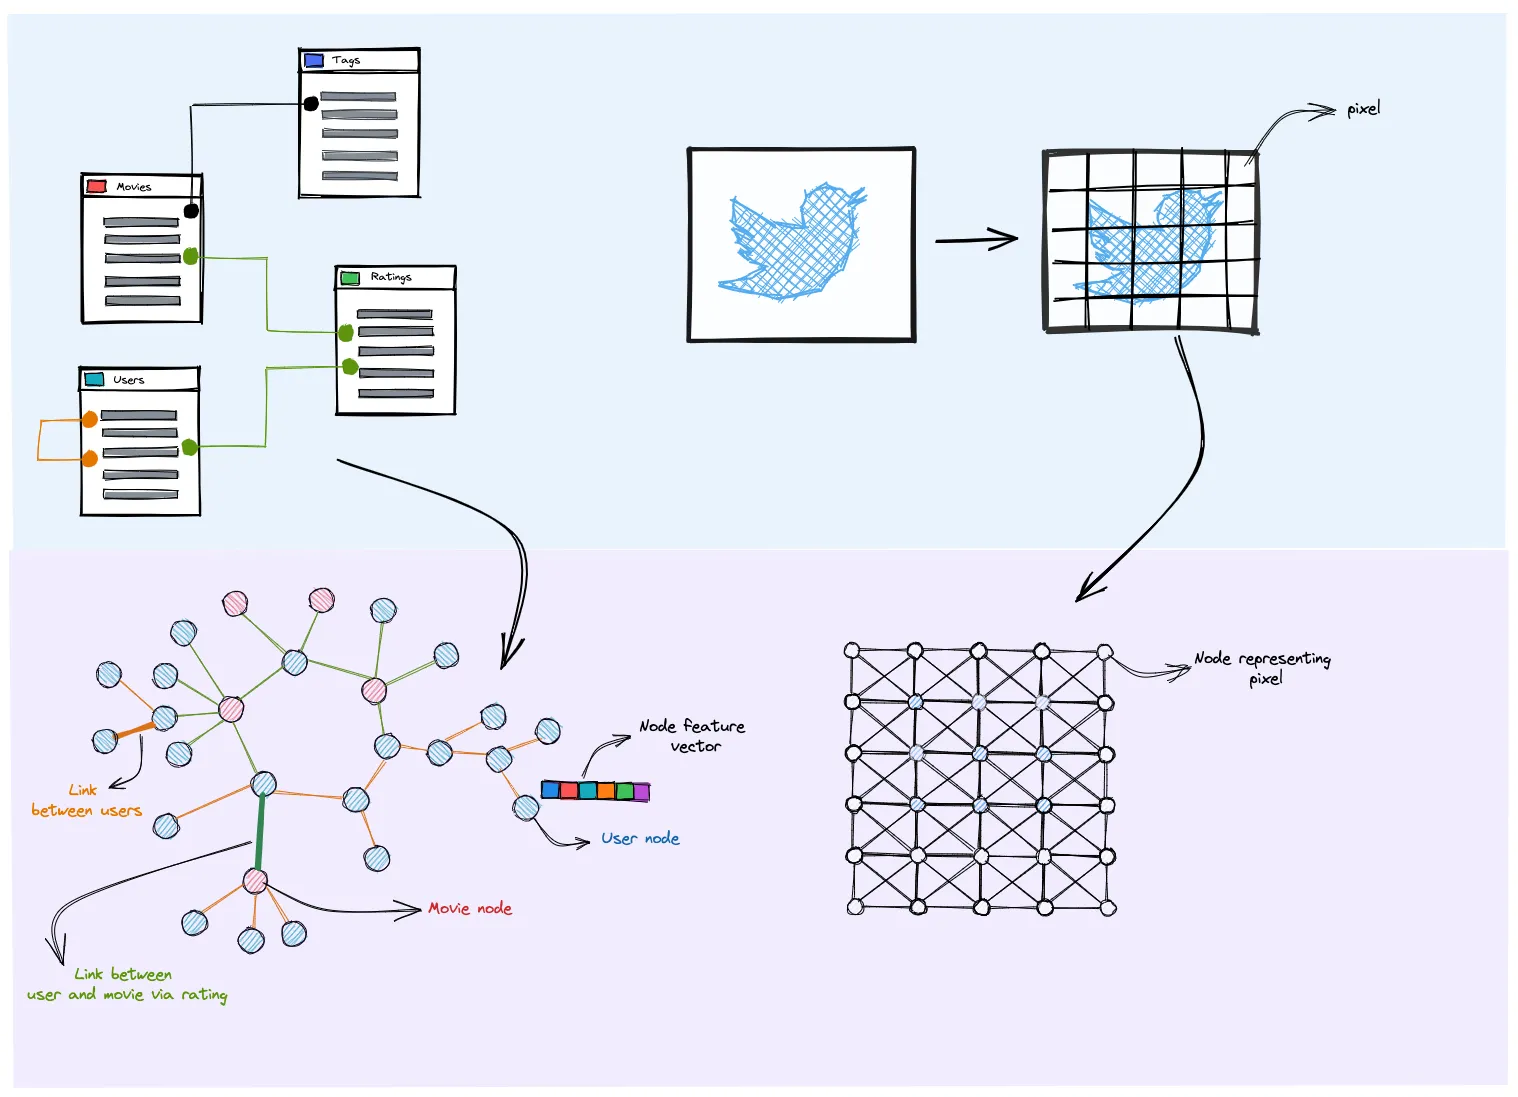

GRAPH CONVOLUTIONAL NETWORKS (GCN) - ICLR 2017

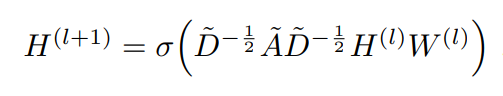

Very simple version: no biases, no normalization, ReLU activation

In [52]:
# Define the Graph Convolutional Layer without normalization
class GraphConvolutionLayer:
    def __init__(self, input_dim, output_dim):
        # Initializes the weight matrix W with small random values
        self.W = np.random.randn(input_dim, output_dim) * 0.01

    def forward(self, A, X):
        # Performs the forward pass (aggregation and transformation)
        return A @ X @ self.W

    def backward(self, A, X, grad_output):
        # Computes gradients for the input features and weights
        grad_input = A @ grad_output @ self.W.T
        grad_W = X.T @ (A @ grad_output)
        return grad_input, grad_W

In [53]:
# Define the GCN model
class GCN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        # two layers
        self.gcn1 = GraphConvolutionLayer(input_dim, hidden_dim)
        self.gcn2 = GraphConvolutionLayer(hidden_dim, output_dim)

    def forward(self, A, X):
        # Performs the forward pass through the layers
        self.H1 = self.gcn1.forward(A, X)
        # ReLU activation
        self.H1_activated = np.maximum(self.H1, 0)
        self.H2 = self.gcn2.forward(A, self.H1_activated)
        # No ReLU activation
        return self.H2


    def backward(self, A, X, grad_output):
        # Backprop through second layer
        grad_output, grad_W2 = self.gcn2.backward(A, self.H1_activated, grad_output)
        # Backprop through ReLU
        grad_output[self.H1 <= 0] = 0
        # Backprop through first layer
        grad_input, grad_W1 = self.gcn1.backward(A, X, grad_output)
        return grad_input, grad_W1, grad_W2

    def predict(self, A, X):
        # Prediction
        H = self.forward(A, X)
        return np.argmax(H, axis=1)

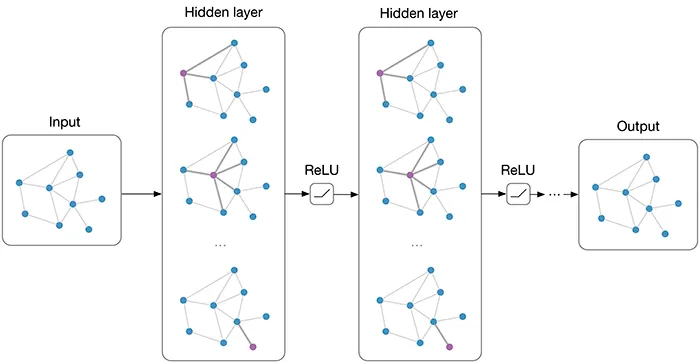

In [54]:
# Training parameters
input_dim = features.shape[1]
hidden_dim = 16
output_dim = len(set(labels))
learning_rate = 0.001
epochs = 50

gcn_model = GCN(input_dim, hidden_dim, output_dim)
labels_one_hot = np.eye(output_dim)[labels]
losses = []

print("Parameters")
print("input_dim:", input_dim)
print("hidden_dim:", hidden_dim)
print("output_dim:", output_dim)
print("learning_rate:", learning_rate)
print("epochs:", epochs)
print("labels", labels_one_hot.shape)
for i in range(5):
    print(labels_one_hot[i])

Parameters
input_dim: 1433
hidden_dim: 16
output_dim: 7
learning_rate: 0.001
epochs: 50
labels (2708, 7)
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]


In [55]:
# One iteration of the training loop
H = gcn_model.forward(A_hat, features)
print("Model output", H.shape)
for i in range(5):
    print(H[i])
# Loss here is mean squared error (MSE)
loss = np.mean((H - labels_one_hot) ** 2)
print("Labels", labels_one_hot.shape)
for i in range(5):
    print(labels_one_hot[i])
print("Loss", loss)

Model output (2708, 7)
[ 0.01511484  0.0067041   0.02468528 -0.01553951  0.01812357  0.01805831
 -0.00580287]
[ 0.01202     0.00796898 -0.00277804 -0.02251531  0.00988753  0.03942717
  0.00222509]
[ 0.02988683  0.00982823 -0.00707595 -0.04311613 -0.00168989  0.10000968
  0.0402009 ]
[-0.00070699 -0.00013415 -0.00030325 -0.00379538  0.00645399  0.00569833
 -0.00276136]
[ 0.00949371  0.00304061  0.00427771 -0.02902466  0.00102108 -0.00450717
 -0.00182986]
Labels (2708, 7)
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
Loss 0.1438960785313017


In [56]:
# Compute gradients
grad_output = 2 * (H - labels_one_hot) / H.shape[0]
print("Gradient", grad_output.shape)
for i in range(5):
    print(grad_output[i])
_, grad_W1, grad_W2 = gcn_model.backward(A_hat, features, grad_output)
gcn_model.gcn1.W -= learning_rate * grad_W1
gcn_model.gcn2.W -= learning_rate * grad_W2
print("Updated W1", gcn_model.gcn1.W.shape)
print("Updated W2", gcn_model.gcn2.W.shape)
print(f'Loss: {loss}')

Gradient (2708, 7)
[ 1.11631047e-05  4.95133089e-06  1.82313736e-05 -7.50029177e-04
  1.33852075e-05  1.33370080e-05 -4.28572063e-06]
[ 8.87739914e-06  5.88551039e-06 -2.05173099e-06 -1.66287406e-05
 -7.31249978e-04  2.91190293e-05  1.64334418e-06]
[ 2.20729934e-05  7.25866658e-06 -5.22596262e-06 -3.18435216e-05
 -7.39800510e-04  7.38623940e-05  2.96904690e-05]
[-7.39074584e-04 -9.90796763e-08 -2.23964423e-07 -2.80308362e-06
  4.76661328e-06  4.20851355e-06 -2.03940724e-06]
[ 7.01160406e-06  2.24564844e-06  3.15931227e-06 -7.59988671e-04
  7.54121299e-07 -3.32878074e-06 -1.35144974e-06]
Updated W1 (1433, 16)
Updated W2 (16, 7)
Loss: 0.1438960785313017


In [57]:
# Training in full
gcn_model = GCN(input_dim, hidden_dim, output_dim)
losses = []
accs = []

for epoch in range(epochs):
    H = gcn_model.forward(A_hat, features)
    loss = np.mean((H - labels_one_hot) ** 2)
    losses.append(loss)
    grad_output = 2 * (H - labels_one_hot) / H.shape[0]
    _, grad_W1, grad_W2 = gcn_model.backward(A_hat, features, grad_output)
    gcn_model.gcn1.W -= learning_rate * grad_W1
    gcn_model.gcn2.W -= learning_rate * grad_W2
    # Evaluation
    predictions = gcn_model.predict(A_hat, features)
    accuracy = np.mean(predictions == labels)
    accs.append(accuracy)
    print(f'Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy:.4f}')

Epoch 0, Loss: 0.1412403655736701, Accuracy: 0.1883
Epoch 1, Loss: 0.14045177377633852, Accuracy: 0.1909
Epoch 2, Loss: 0.13972768583266285, Accuracy: 0.1939
Epoch 3, Loss: 0.13905672696848126, Accuracy: 0.1968
Epoch 4, Loss: 0.13843465426603607, Accuracy: 0.1972
Epoch 5, Loss: 0.13789310604569655, Accuracy: 0.2042
Epoch 6, Loss: 0.1373805163586916, Accuracy: 0.2083
Epoch 7, Loss: 0.13689486395563347, Accuracy: 0.2123
Epoch 8, Loss: 0.1364341302835909, Accuracy: 0.2175
Epoch 9, Loss: 0.13599525369575288, Accuracy: 0.2238
Epoch 10, Loss: 0.13557487395609596, Accuracy: 0.2290
Epoch 11, Loss: 0.1351737792232144, Accuracy: 0.2422
Epoch 12, Loss: 0.13479077173308157, Accuracy: 0.2559
Epoch 13, Loss: 0.13442358800232557, Accuracy: 0.2829
Epoch 14, Loss: 0.1340779978846891, Accuracy: 0.2987
Epoch 15, Loss: 0.1337566821804617, Accuracy: 0.3098
Epoch 16, Loss: 0.13344823700421835, Accuracy: 0.3154
Epoch 17, Loss: 0.13315276874500412, Accuracy: 0.3213
Epoch 18, Loss: 0.1328668004783809, Accuracy

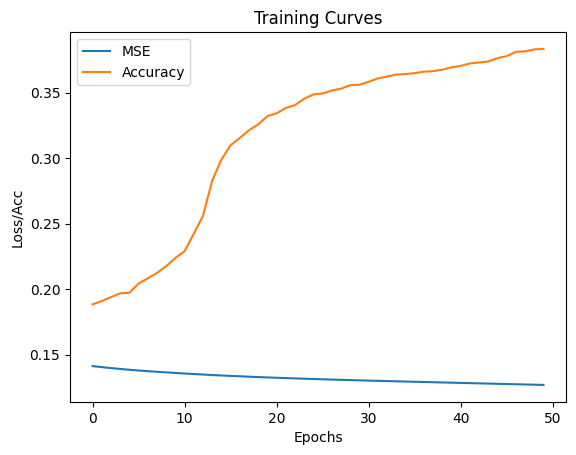

In [58]:
# Plotting the loss curve
plt.plot(losses, label='MSE')
plt.plot(accs, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Acc')
plt.title('Training Curves')
plt.legend()
plt.show()

In [59]:
# Training with PyTorch Geometric's built-in GCN layer
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Define the GCN model using PyG
class PyG_GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(PyG_GCN, self).__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.convs.append(GCNConv(hidden_dim, output_dim))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
        x = self.convs[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

# Set parameters
num_layers = 4
epochs = 100
input_dim = dataset.num_node_features
hidden_dim = 16
output_dim = dataset.num_classes
model = PyG_GCN(input_dim, hidden_dim, output_dim, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

# Training loop
model.train()
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Evaluation on training data
    _, pred = out[data.train_mask].max(dim=1)
    correct = float(pred.eq(data.y[data.train_mask]).sum().item())
    train_accuracy = correct / data.train_mask.sum().item()

    # Evaluation on validation data
    _, pred = out[data.val_mask].max(dim=1)
    correct = float(pred.eq(data.y[data.val_mask]).sum().item())
    val_accuracy = correct / data.val_mask.sum().item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

print('Training complete with PyG.')

# Evaluate the PyG model on test data
model.eval()
out = model(data)
_, pred = out[data.test_mask].max(dim=1)
correct = float(pred.eq(data.y[data.test_mask]).sum().item())
test_accuracy = correct / data.test_mask.sum().item()

print(f'Final Test Accuracy with PyG: {test_accuracy:.4f}')

Total number of parameters: 23607
Epoch 0, Loss: 1.9418526887893677, Train Accuracy: 0.2143, Val Accuracy: 0.1360
Epoch 10, Loss: 1.8782356977462769, Train Accuracy: 0.4357, Val Accuracy: 0.2880
Epoch 20, Loss: 1.760593056678772, Train Accuracy: 0.4643, Val Accuracy: 0.2900
Epoch 30, Loss: 1.6014732122421265, Train Accuracy: 0.6286, Val Accuracy: 0.3720
Epoch 40, Loss: 1.418674349784851, Train Accuracy: 0.7214, Val Accuracy: 0.5520
Epoch 50, Loss: 1.218254804611206, Train Accuracy: 0.7857, Val Accuracy: 0.6340
Epoch 60, Loss: 1.0082569122314453, Train Accuracy: 0.8214, Val Accuracy: 0.6680
Epoch 70, Loss: 0.7961968779563904, Train Accuracy: 0.9071, Val Accuracy: 0.7120
Epoch 80, Loss: 0.5944827795028687, Train Accuracy: 0.9643, Val Accuracy: 0.7480
Epoch 90, Loss: 0.42466646432876587, Train Accuracy: 0.9786, Val Accuracy: 0.7160
Training complete with PyG.
Final Test Accuracy with PyG: 0.7250


### Exercise

1. In the PyG implementation, we only use a hidden dimension of 16. Try to add more and run the model. What are the effects of adding more parameters? Any possible issues adding too many parameters may cause?


2. Also, we only use 4 layers. Try to add more and run the model. What is the effect of adding more layers?


3. Keep note of the number of parameters in the model. Within a 50,000 parameter budget, try to achieve the highest accuracy by changing the hidden dimension and layer count.

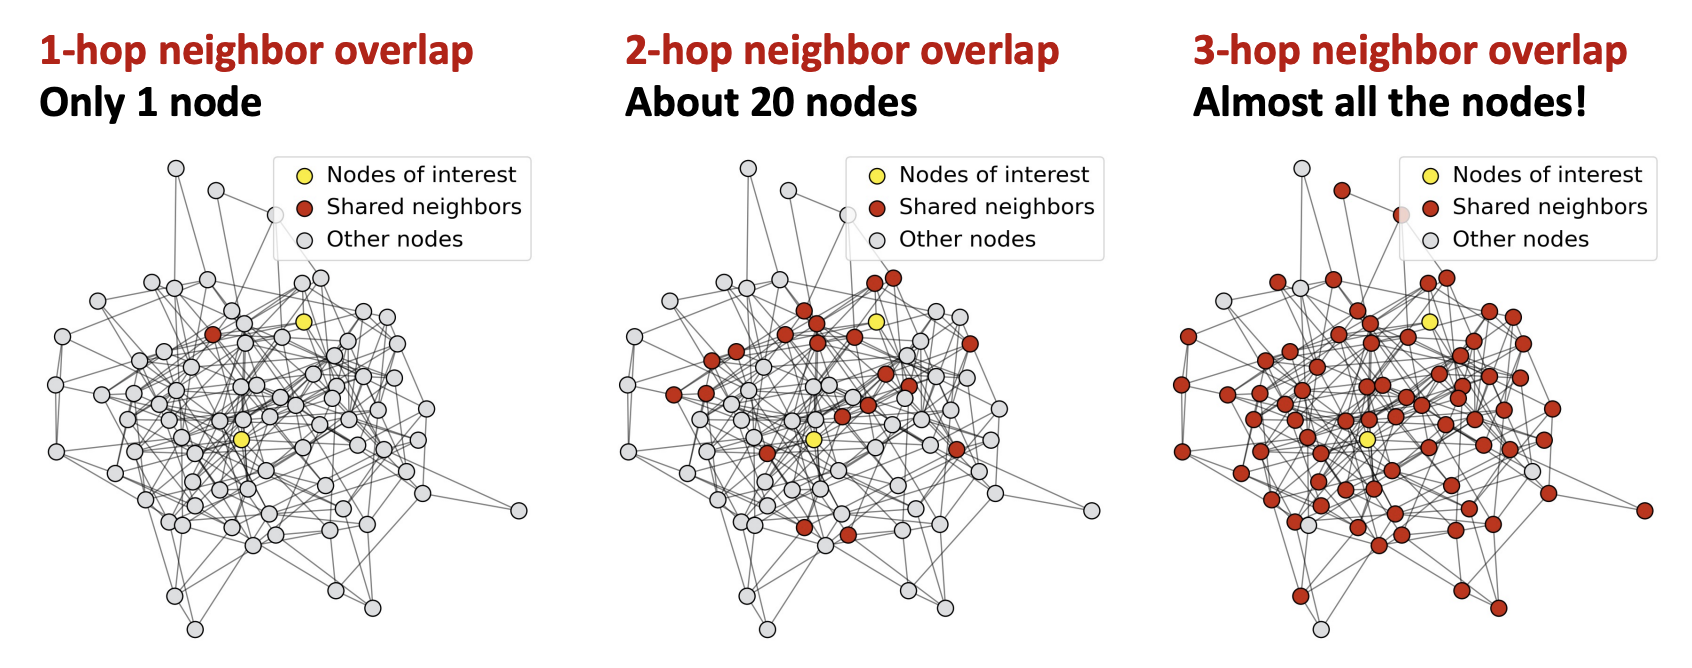

References:

https://medium.com/@kaoningyu/introduction-of-graph-convolutional-network-gcn-quick-implementation-5dd75e75b261
https://web.stanford.edu/class/cs224w/index.html#content
